<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Ragnar Betancourt.

**Fecha:** 27 de Noviembre del 2021.

**Expediente** : if717467 .
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/betancourtp09/SPf_Tarea9-Betancourt

# Tarea 9: Clase 23

Implementar el método de esquemas del trapecio, para valuar la opción call y put asiática con precio inicial, $S_0 = 100$, precio de ejercicio $K = 100$, tasa libre de riesgo $r = 0.10$, volatilidad $\sigma = 0.20$ y $T = 1$ año. Cuyo precio es $\approx 7.04$. Realizar la simulación en base a la siguiente tabla:


Observe que en esta tabla se encuentran los intervalos de confianza de la aproximación obtenida y además el tiempo de simulación que tarda en encontrar la respuesta cada método. 
- Se debe entonces realizar una simulación para la misma cantidad de trayectorias y número de pasos y construir una Dataframe de pandas para reportar todos los resultados obtenidos.**(70 puntos)**
- Compare los resultados obtenidos con los resultados arrojados por la función `Riemann_approach`. Concluya. **(30 puntos)**

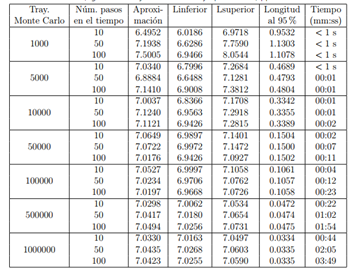

In [1]:
#Librerias
import time
import numpy as np
import pandas as pd
import scipy.stats as st

In [2]:
# Función para ecuacion Black-Scholes
def F_BS(mu, sigma, S0, NbTraj, T, NbStep):
    nu = mu - (sigma**2) / 2 
    DeltaT = T / NbStep # particiones en el tiempo
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT * np.random.randn(NbTraj, NbStep - 1)
    increments = nu * DeltaT + sigma * DeltaW 
    concat = np.concatenate((np.log(S0) * np.ones([NbTraj, 1]), increments), axis = 1)
    LogSt = np.cumsum(concat, axis = 1) 
    St = np.exp(LogSt) 
    t = np.arange(0, NbStep) # cantidad de días simulados
    return St.T, t

In [3]:
# Función para calcular rendimientos diarios
def daily_ret(closes):
    return np.log(closes / closes.shift(1)).iloc[1:]

In [4]:
#Función para calcular la aproximación por el Esquema del Trapecio 
def E_Trapecio(K, r, S0, NbTraj, NbStep, sigma, T, tipo):
    tiempo_inicial = time.time() 
    St, t = F_BS(r, sigma, S0, NbTraj, T, NbStep) 
    prices = pd.DataFrame(St, index = t)
    h = T / NbStep
    p_prom = np.cumsum(prices * (2 + r * h + np.random.randn(NbStep, NbTraj) * sigma)) * h / (2 * T) # precios promedio
    strike = K 
    if tipo == "call":# Calcular call de la opción
        primas = pd.DataFrame({"Prima": np.exp(-r * T) * np.fmax(p_prom - strike, 0).mean(axis = 1)}, index = t)
    else:# Calcular el put de la opción 
        primas = pd.DataFrame({"Prima": np.exp(-r * T) * np.fmax(strike - p_prom, 0).mean(axis = 1)}, index = t)
    confianza = 0.95 
    sigma_est = primas.sem().Prima 
    mean_est = primas.iloc[-1].Prima 
    i = st.norm.interval(confianza, loc = mean_est, scale = sigma_est) 
    long_int = i[1] - i[0] 
    tiempo_fin = time.time() 
    tiempo = int(tiempo_fin - tiempo_inicial)
    return ["%.4f" % round(primas.iloc[-1].Prima, 4), "%.4f" % round(i[0], 4), "%.4f" % round(i[1], 4), 
           "%.4f" % round(long_int, 4), "{:02d}:{:02d}".format((tiempo % 3600 // 60), tiempo % 60)] 

In [5]:
# Función para calcular la aproximación por sumas de Riemann 
def Riemann_a(K, r, S0, NbTraj, NbStep, sigma, T, tipo):
    tiempo_inicial = time.time() 
    St, t = F_BS(r, sigma, S0, NbTraj, T, NbStep) 
    prices = pd.DataFrame(St, index = t) 
    p_prom = prices.expanding().mean() 
    strike = K 
    if tipo == "call":
        primas = pd.DataFrame({"Prima": np.exp(-r * T) * np.fmax(p_prom - strike, 0).mean(axis = 1)}, index = t)
    else:
        primas = pd.DataFrame({"Prima": np.exp(-r * T) * np.fmax(strike - p_prom, 0).mean(axis = 1)}, index = t)
    confianza = 0.95 
    sigma_est = primas.sem().Prima 
    mean_est = primas.iloc[-1].Prima 
    i = st.norm.interval(confianza, loc = mean_est, scale = sigma_est) 
    long_int = i[1] - i[0]
    tiempo_fin = time.time() 
    tiempo = int(tiempo_fin - tiempo_inicial) 
    return ["%.4f" % round(primas.iloc[-1].Prima, 4), "%.4f" % round(i[0], 4), "%.4f" % round(i[1], 4), 
           "%.4f" % round(long_int, 4), "{:02d}:{:02d}".format((tiempo % 3600 // 60), tiempo % 60)]

In [6]:
# Función para formato de tiempo
def formato_tiempo(x):
    if x == "00:00":
        return "< 1 s"
    else:
        return x

In [7]:
# Datos del problema 
S0 = 100 
r = 0.10 
sigma = 0.2 
K = 100
T = 1 
NbTraj = [1000, 5000, 10000, 50000, 100000, 500000, 1000000] # número de trayectorias 
NbStep = [10, 50, 100] # número de pasos en el tiempo

## call black scholes

In [8]:
#esquema de trapecios

call_trap = list(map(lambda N_traj: list(map(lambda N_step: E_Trapecio(K, r, S0, N_traj, N_step, sigma, T, "call"), 
                                                NbStep)), NbTraj))
niv = len(NbStep) # número de subíndices
f1 = list(map(lambda i: int(i / niv), range(7 * niv))) 
f2 = list(map(lambda i: int(i % niv), range(7 * niv))) 
indx = pd.MultiIndex(levels = [NbTraj, NbStep], codes = [f1, f2])
call_trap_array = np.array([call_trap[f1[i]][f2[i]] for i in range(len(f1))]) 
call_trap_table = pd.DataFrame(index = indx, columns = ["Aproximación", "Linferior", "Lsuperior", 
                                                        "Longitud al 95%", "Tiempo (mm:ss)"])
call_trap_table.index.names = (["Tray. MonteCarlo", "Núm. pasos en el tiempo"])
call_trap_table["Aproximación"] = call_trap_array.T[0]
call_trap_table["Linferior"] = call_trap_array.T[1]
call_trap_table["Lsuperior"] = call_trap_array.T[2]
call_trap_table["Longitud al 95%"] = call_trap_array.T[3]
call_trap_table["Tiempo (mm:ss)"] = np.array(pd.Series(call_trap_array.T[4]).apply(formato_tiempo)) 
call_trap_table

Aproximación Linferior Lsuperior  \
Tray. MonteCarlo Núm. pasos en el tiempo                                    
1000             10                            6.6805    5.3709    7.9901   
                 50                            7.1489    6.7246    7.5732   
                 100                           7.1315    6.8499    7.4130   
5000             10                            6.8562    5.5118    8.2006   
                 50                            7.0632    6.6470    7.4794   
                 100                           6.8721    6.6042    7.1400   
10000            10                            6.9281    5.5697    8.2865   
                 50                            7.1011    6.6803    7.5220   
                 100                           7.1059    6.8263    7.3855   
50000            10                            6.8698    5.5223    8.2174   
                 50                            7.0429    6.6260    7.4598   
                 100                           6.9999    6.7248    7.2751   
100000           10                            6.9194    5.5622    8.2766   
                 50                            7.0120    6.5978    7.4263   
                 100                           7.0252    6.7489    7.3014   
500000           10                            6.8835    5.5335    8.2334   
                 50                            7.0317    6.6162    7.4472   
                 100                           7.0371    6.7603    7.3140   
1000000          10                            6.9070    5.5524    8.2617   
                 50                            7.0137    6.5996    7.4278   
                 100                           7.0129    6.7372    7.2887   

                                         Longitud al 95% Tiempo (mm:ss)  
Tray. MonteCarlo Núm. pasos en el tiempo                                 
1000             10                               2.6192          < 1 s  
                 50                               0.8486          < 1 s  
                 100                              0.5631          < 1 s  
5000             10                               2.6888          < 1 s  
                 50                               0.8323          < 1 s  
                 100                              0.5358          < 1 s  
10000            10                               2.7168          < 1 s  
                 50                               0.8417          < 1 s  
                 100                              0.5592          < 1 s  
50000            10                               2.6950          < 1 s  
                 50                               0.8338          < 1 s  
                 100                              0.5503          00:01  
100000           10                               2.7144          < 1 s  
                 50                               0.8286          00:01  
                 100                              0.5525          00:02  
500000           10                               2.7000          00:02  
                 50                               0.8310          00:06  
                 100                              0.5536          00:20  
1000000          10                               2.7093          00:05  
                 50                               0.8283          00:13  
                 100                              0.5514          00:45

In [9]:
#sumas de riemann
call_riemann = list(map(lambda N_traj: list(map(lambda N_step: Riemann_a(K, r, S0, N_traj, N_step, sigma, T, "call"), 
                                                NbStep)), NbTraj))
call_riemann_array = np.array([call_riemann[f1[i]][f2[i]] for i in range(len(f1))]) 
call_riemann_table = pd.DataFrame(index = indx, columns = ["Aproximación", "Linferior", "Lsuperior", 
                                                           "Longitud al 95%", "Tiempo (mm:ss)"]) 
call_riemann_table.index.names = (["Tray. MonteCarlo", "Núm. pasos en el tiempo"])
call_riemann_table["Aproximación"] = call_riemann_array.T[0]
call_riemann_table["Linferior"] = call_riemann_array.T[1]
call_riemann_table["Lsuperior"] = call_riemann_array.T[2]
call_riemann_table["Longitud al 95%"] = call_riemann_array.T[3]
call_riemann_table["Tiempo (mm:ss)"] = np.array(pd.Series(call_riemann_array.T[4]).apply(formato_tiempo)) 
call_riemann_table

Aproximación Linferior Lsuperior  \
Tray. MonteCarlo Núm. pasos en el tiempo                                    
1000             10                            6.4240    5.1675    7.6805   
                 50                            7.2589    6.7114    7.8064   
                 100                           6.7629    6.4176    7.1082   
5000             10                            6.5258    5.2279    7.8236   
                 50                            6.7970    6.2955    7.2985   
                 100                           6.9725    6.6143    7.3307   
10000            10                            6.4382    5.1569    7.7195   
                 50                            6.9055    6.3918    7.4192   
                 100                           6.9204    6.5639    7.2768   
50000            10                            6.4443    5.1651    7.7235   
                 50                            6.8619    6.3505    7.3733   
                 100                           6.9737    6.6153    7.3321   
100000           10                            6.3952    5.1281    7.6623   
                 50                            6.8958    6.3819    7.4096   
                 100                           7.0127    6.6511    7.3743   
500000           10                            6.4394    5.1630    7.7158   
                 50                            6.9307    6.4133    7.4481   
                 100                           6.9878    6.6276    7.3481   
1000000          10                            6.4369    5.1604    7.7134   
                 50                            6.9081    6.3925    7.4237   
                 100                           6.9764    6.6169    7.3360   

                                         Longitud al 95% Tiempo (mm:ss)  
Tray. MonteCarlo Núm. pasos en el tiempo                                 
1000             10                               2.5129          < 1 s  
                 50                               1.0950          < 1 s  
                 100                              0.6905          < 1 s  
5000             10                               2.5958          < 1 s  
                 50                               1.0030          < 1 s  
                 100                              0.7164          < 1 s  
10000            10                               2.5626          < 1 s  
                 50                               1.0273          < 1 s  
                 100                              0.7129          < 1 s  
50000            10                               2.5584          00:01  
                 50                               1.0228          00:01  
                 100                              0.7168          00:02  
100000           10                               2.5342          00:02  
                 50                               1.0277          00:03  
                 100                              0.7232          00:04  
500000           10                               2.5528          00:14  
                 50                               1.0348          00:18  
                 100                              0.7205          00:20  
1000000          10                               2.5530          00:25  
                 50                               1.0312          00:31  
                 100                              0.7191          00:54

El metodo de esquema de trapecios es mas eficiente tanto en tiempo como en aproximación.

## PUT black scholes

In [10]:
#esquema de trapecios
put_trap = list(map(lambda N_traj: list(map(lambda N_step: E_Trapecio(K, r, S0, N_traj, N_step, sigma, T, "put"), 
                                            NbStep)), NbTraj))
put_trap_array = np.array([put_trap[f1[i]][f2[i]] for i in range(len(f1))]) 
put_trap_table = pd.DataFrame(index = indx, columns = ["Aproximación", "Linferior", "Lsuperior", 
                                                       "Longitud al 95%", "Tiempo (mm:ss)"]) 
put_trap_table.index.names = (["Tray. MonteCarlo", "Núm. pasos en el tiempo"]) 
put_trap_table["Aproximación"] = put_trap_array.T[0]
put_trap_table["Linferior"] = put_trap_array.T[1]
put_trap_table["Lsuperior"] = put_trap_array.T[2]
put_trap_table["Longitud al 95%"] = put_trap_array.T[3]
put_trap_table["Tiempo (mm:ss)"] = np.array(pd.Series(put_trap_array.T[4]).apply(formato_tiempo)) 
put_trap_table


Aproximación Linferior Lsuperior  \
Tray. MonteCarlo Núm. pasos en el tiempo                                    
1000             10                            2.3188  -14.7434   19.3810   
                 50                            2.5250   -4.9070    9.9569   
                 100                           2.4007   -2.8517    7.6530   
5000             10                            2.3356  -14.7462   19.4174   
                 50                            2.3160   -5.1482    9.7803   
                 100                           2.2312   -3.0365    7.4990   
10000            10                            2.1580  -14.9760   19.2921   
                 50                            2.3017   -5.1663    9.7698   
                 100                           2.3602   -2.8972    7.6175   
50000            10                            2.2049  -14.9170   19.3269   
                 50                            2.3094   -5.1560    9.7748   
                 100                           2.3252   -2.9352    7.5856   
100000           10                            2.2314  -14.8814   19.3442   
                 50                            2.3331   -5.1287    9.7950   
                 100                           2.3330   -2.9257    7.5918   
500000           10                            2.2192  -14.8995   19.3379   
                 50                            2.3265   -5.1368    9.7899   
                 100                           2.3377   -2.9210    7.5963   
1000000          10                            2.2271  -14.8889   19.3430   
                 50                            2.3319   -5.1296    9.7933   
                 100                           2.3438   -2.9141    7.6016   

                                         Longitud al 95% Tiempo (mm:ss)  
Tray. MonteCarlo Núm. pasos en el tiempo                                 
1000             10                              34.1244          < 1 s  
                 50                              14.8639          < 1 s  
                 100                             10.5047          < 1 s  
5000             10                              34.1636          < 1 s  
                 50                              14.9285          < 1 s  
                 100                             10.5355          < 1 s  
10000            10                              34.2681          < 1 s  
                 50                              14.9360          < 1 s  
                 100                             10.5148          < 1 s  
50000            10                              34.2438          < 1 s  
                 50                              14.9308          < 1 s  
                 100                             10.5208          00:01  
100000           10                              34.2255          < 1 s  
                 50                              14.9237          00:01  
                 100                             10.5174          00:02  
500000           10                              34.2374          00:02  
                 50                              14.9267          00:06  
                 100                             10.5172          00:11  
1000000          10                              34.2318          00:04  
                 50                              14.9228          00:12  
                 100                             10.5157          00:44

In [12]:
#sumas de riemann
put_riemann = list(map(lambda N_traj: list(map(lambda N_step: Riemann_a(K, r, S0, N_traj, N_step, sigma, T, "put"), 
                                               NbStep)), NbTraj))
put_riemann_array = np.array([put_riemann[f1[i]][f2[i]] for i in range(len(f1))]) 
put_riemann_table = pd.DataFrame(index = indx, columns = ["Aproximación", "Linferior", "Lsuperior", 
                                                          "Longitud al 95%", "Tiempo (mm:ss)"]) 
put_riemann_table.index.names = (["Tray. MonteCarlo", "Núm. pasos en el tiempo"]) 
put_riemann_table["Aproximación"] = put_riemann_array.T[0]
put_riemann_table["Linferior"] = put_riemann_array.T[1]
put_riemann_table["Lsuperior"] = put_riemann_array.T[2]
put_riemann_table["Longitud al 95%"] = put_riemann_array.T[3]
put_riemann_table["Tiempo (mm:ss)"] = np.array(pd.Series(put_riemann_array.T[4]).apply(formato_tiempo)) 
put_riemann_table

Aproximación Linferior Lsuperior  \
Tray. MonteCarlo Núm. pasos en el tiempo                                    
1000             10                            2.0240    1.6422    2.4059   
                 50                            2.2252    2.0871    2.3633   
                 100                           2.4462    2.3393    2.5530   
5000             10                            2.2010    1.7805    2.6214   
                 50                            2.3632    2.2117    2.5147   
                 100                           2.2749    2.1800    2.3698   
10000            10                            2.2044    1.7820    2.6267   
                 50                            2.3297    2.1821    2.4773   
                 100                           2.3753    2.2756    2.4750   
50000            10                            2.1982    1.7767    2.6197   
                 50                            2.3300    2.1824    2.4776   
                 100                           2.3246    2.2257    2.4235   
100000           10                            2.2156    1.7915    2.6397   
                 50                            2.3291    2.1812    2.4770   
                 100                           2.3355    2.2367    2.4342   
500000           10                            2.2144    1.7901    2.6388   
                 50                            2.3271    2.1799    2.4742   
                 100                           2.3460    2.2463    2.4457   
1000000          10                            2.2269    1.7999    2.6538   
                 50                            2.3356    2.1876    2.4836   
                 100                           2.3555    2.2552    2.4558   

                                         Longitud al 95% Tiempo (mm:ss)  
Tray. MonteCarlo Núm. pasos en el tiempo                                 
1000             10                               0.7637          < 1 s  
                 50                               0.2761          < 1 s  
                 100                              0.2137          < 1 s  
5000             10                               0.8409          < 1 s  
                 50                               0.3030          < 1 s  
                 100                              0.1898          < 1 s  
10000            10                               0.8447          < 1 s  
                 50                               0.2953          < 1 s  
                 100                              0.1993          < 1 s  
50000            10                               0.8430          00:01  
                 50                               0.2952          00:01  
                 100                              0.1978          00:01  
100000           10                               0.8482          00:02  
                 50                               0.2958          00:03  
                 100                              0.1975          00:04  
500000           10                               0.8487          00:13  
                 50                               0.2944          00:15  
                 100                              0.1995          00:19  
1000000          10                               0.8540          00:25  
                 50                               0.2960          00:32  
                 100                              0.2006          01:00

En este caso la aproximacion por sumas de riemann de igual manera tardo mas, creo que en la prima se asemejan bastante en este caso de put, la longitud fue bastante mas alta en las simulaciones hechas con esquema de trapecios, en general pudiera concluir que en ambos casos las dos formas de aproximar son buenas solo que riemann dura mas en los dos casos